# Link Prediction
In this notebook, we perform linkperdiction and compare obtained result for both $D_{sas}$ and $D_{obs}$ dataset. We will generate noble features using metadata information and perform *LSTM* based timeseries forecasting and link classification using those features.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import graph as gr
import utils as ut
import feature_selection as fs
import classification as cl
import os.path
import matplotlib.pyplot as plt
from pprint import pprint
import importlib
import community
import seaborn as sns
from gensim.models import KeyedVectors
from pyemd import emd
from gensim import corpora
from nltk.corpus import stopwords
from gensim.matutils import softcossim
import copy
import itertools
import pickle

Using Theano backend.
C:\Users\faisal\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Dropout, Activation, Reshape
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import load_model

In [3]:
#word_vectors = KeyedVectors.load_word2vec_format('pubmed2018_w2v_200D/pubmed2018_w2v_200D.bin', binary=True)

#### Path for dataset and other files.

In [19]:
#########dataset and domain selection : sleep apnea: 0 ; obesity:1
importlib.reload(ut)
select_domain  = 0
domain = ['apnea','obesity']
root = '../linkPrediction/'
filepath=[['dataset/apnea-all,3.csv',
         'dataset/apnea-distinct_keyword.csv'],
        ['dataset/obesity-all,3.csv',
         'dataset/obesity-distinct_keyword.csv']]
########path to save graph files
graphpath=root+'graphs/'+domain[select_domain]
########path to save result files, data files and resultent figures
datapath=root+'dataframes/'+domain[select_domain]
#path to save classification models
modelpath=root+'models/'+domain[select_domain]
########columns with sub-columns
column_split=['keyword','author_name','affiliation_1','affiliation_2','country']
#time=[parent_year, train:start_year, test:start_year, no_of_test_years(1), total_year_in_each_iteration, no of grandparents]
time=[2007,2008,2015,1,1,20]
######load dataset and keyword list into dataframes
df, key_list = ut.load_dataset(filepath[select_domain], column_split)

#### print a file path

In [20]:
graphpath

'../linkPrediction/graphs/apnea'

#### graph building and saving in graphpath

In [10]:
#######graph building and saving in graphpath: train graph, test graph and parent graph(previous year of train graph)  
importlib.reload(gr)
# time=[1991,1992,1994,1,1,20]
gr.dynamic_train_test_graph_build(df, key_list, graphpath, time)

0
../linkPrediction/graphs/obesity\train_graph_1992.gpickle saved, nodes: 0 edges: 0
../linkPrediction/graphs/obesity\train_graph_1993.gpickle saved, nodes: 0 edges: 0
../linkPrediction/graphs/obesity\test_graph_1994.gpickle saved, nodes: 0 edges: 0
../linkPrediction/graphs/obesity\parent_graph_1991-1992.gpickle saved, nodes: 0 edges: 0
../linkPrediction/graphs/obesity\train_graph_1992-1994.gpickle saved, nodes: 0 edges: 0
../linkPrediction/graphs/obesity\test_graph_1994-1995.gpickle saved, nodes: 0 edges: 0


#### Load all graphs into dictionary of networkx graphs

In [21]:
# time=[1991,1992,1994,1,1,20]
g_train, g_test, g_parent, g_train_static, g_test_static = gr.graph_load(graphpath, time)

../linkPrediction/graphs/apnea\train_graph_2008.gpickle loaded, nodes: 459 edges: 773
../linkPrediction/graphs/apnea\train_graph_2009.gpickle loaded, nodes: 470 edges: 688
../linkPrediction/graphs/apnea\train_graph_2010.gpickle loaded, nodes: 496 edges: 786
../linkPrediction/graphs/apnea\train_graph_2011.gpickle loaded, nodes: 536 edges: 977
../linkPrediction/graphs/apnea\train_graph_2012.gpickle loaded, nodes: 584 edges: 1054
../linkPrediction/graphs/apnea\train_graph_2013.gpickle loaded, nodes: 634 edges: 1280
../linkPrediction/graphs/apnea\train_graph_2014.gpickle loaded, nodes: 583 edges: 1144
../linkPrediction/graphs/apnea\test_graph_2015.gpickle loaded, nodes: 1093 edges: 2019
../linkPrediction/graphs/apnea\parent_graph_2007-2008.gpickle loaded, nodes: 388 edges: 689
../linkPrediction/graphs/apnea\train_graph_2008-2015.gpickle loaded, nodes: 1093 edges: 5142
../linkPrediction/graphs/apnea\test_graph_2015-2016.gpickle loaded, nodes: 1093 edges: 2019


#### Node level and edge level feature generation 

In [16]:
importlib.reload(fs)
importlib.reload(cl)
#ration of negative:positive train instance:(eg,10 for 10:1=neg:pos)
freq=10
#time=[2001,2007,2015,1,1,10]
#train_data building: dictionary of each years non-connected node pairs dataframes
train_data, train_data_static, parent_data, test_data_static, edge_list = cl.non_edge_feature_dataframe(g_train, 
                                                                                                         g_test,
                                                                                                         g_parent,
                                                                                                         g_train_static, 
                                                                                                         g_test_static,  
                                                                                                         time, 
                                                                                                         freq)
#train_data: non-connected node pairs with feature values
#node_features: node feature values
node_feature, train_data = fs.dynamic_graph_feature_set(df, key_list, train_data, g_parent, g_train, g_train_static, time)

pos
test_size: 13396
neg
test_size: 8027337
pos in time series: 13073 neg in time series: 121325 pos-neg ratio: 0.10775190603750258 total: 134398


#### Save train_data and node_feature into filepath
filepath: path to save result files, data files and resultent figures

In [17]:
importlib.reload(ut)
ut.save_data(train_data, datapath, domain[select_domain], "train_data", time)
ut.save_data(node_feature, datapath, domain[select_domain], "node_feature", time)
ut.save_data(edge_list, datapath, domain[select_domain], "edge_list", time)

../linkPrediction/dataframes/obesity\obesity-train_data_2008-2015.pkl
../linkPrediction/dataframes/obesity\obesity-node_feature_2008-2015.pkl
../linkPrediction/dataframes/obesity\obesity-edge_list_2008-2015.pkl


#### Print positive-negative training instance stats and other information

In [18]:
#positive instance no
print(len(train_data_static[(train_data_static['label']==1)]))
#negative instance no
print(len(train_data_static[(train_data_static['label']==0)]))
#no of total nodes
print(len(g_train_static.nodes()))
#no of total train graph edges
print(len(g_train_static.edges()))
#no of total test graph edges
print(len(g_test_static.edges()))

13396
133960
4027
65618
21650


In [ ]:
ts=time[1]
row = train_data[ts].columns.values.tolist()
######feature column names
feature_names = row[2:len(row)]
#X,y, data_len_dm = cl.reshape_feature_data_for_classification(train_data, edge_list, time)
columns_drop = list(set(feature_names).difference(set(['citation1'])))
pruned_data = copy.deepcopy(train_data)
pruned_data = fs.drop_feature_columns(pruned_data, columns_drop, time)
#data reshape for classification model (data_len_dm=[input sample length, input dimension, output dimension])
X,y, data_len_dm = cl.reshape_feature_data_for_classification(pruned_data, edge_list, time)

X shape: (12432, 7, 1) y shape: (12432,)


#### Extract node_feature and train_data from saved files

In [22]:
importlib.reload(ut)
train_data = ut.load_data(datapath, domain[select_domain], "train_data", time)
node_feature = ut.load_data(datapath, domain[select_domain], "node_feature", time)
edge_list = ut.load_data(datapath, domain[select_domain], "edge_list", time)
print('train data length:',len(train_data))
print('node feature length:',len(node_feature))
print('edge_list length:',len(edge_list))

../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
train data length: 7
node feature length: 7
edge_list length: 12527


#### Print sample data

In [12]:
node_feature[2009].head()
# train_data[2008].head()

,node_index,y_weight,term_art,term_aut,term_af1,term_af2,term_coun,closeness,degree,citation,degrees,node_type_aut,node_type_art,node_type_deg
0,9861,1,-1.045279,-2.826773,-2.337996,-0.729760,-0.715418,0.000000,0,10,0.000000,1,1,1
1,494,1,1.005852,0.820151,0.844694,1.504672,1.219134,0.156265,7,200,0.098592,5,5,5
2,15200,1,-0.435987,-1.352994,-2.144696,-1.104996,-0.746827,0.126229,1,50,0.014085,3,3,3
3,4836,1,3.580582,2.935343,3.519190,2.591645,2.635648,0.219626,11,308,0.154930,20,20,20
4,2559,1,-1.045279,0.279146,-0.971152,0.170829,0.243525,0.000000,0,23,0.000000,1,1,1


### Model training
1. Defining list of features
2. Data reshaping to feed into *LSTM* network
3. Test-train split
4. Normalized and reshaped data $(X,y)$ saving
5. Model training: forecasting and link classification
6. Saving model file
7. Evaluating model on test dataset
8. Result saving

In [281]:
#model training-------feature list creation->data reshape->test-train split->training->model save->evaluating->result save
importlib.reload(fs)
importlib.reload(cl)
#training start year
ts = time[1]
#####training end year+1/ test year
te = time[2]

row = train_data[ts].columns.values.tolist()
######feature column names
feature_names = row[2:len(row)]
#####all possible combinations of features: will be used in case of multiple feature combination
all_combinations = itertools.chain(*[itertools.combinations(feature_names, i + 1)
                                     for i, _ in enumerate(feature_names)])
feature_list = list(all_combinations)
#######single feature based model building for each feature in the set of selective_features [our experiment]
selective_features =  set(['typeaut','typeart','typenode','cm','pref','citation1'])
# selective_features =  set(['typeaut','typeart','typenode'])
#domain_info(eg. obesity-2008-2015)
domain_info =  domain[select_domain]+"-"+str(ts)+"-"+str(te)+"-"
models  = []
results = []
#number of epochs and batch size in each epoch
con = [20,64]
batch_size = con[1]
for feature in feature_list:
    #drop feature columns for features which are not in the feature combination
    columns_drop = list(set(feature_names).difference(set(feature)))
    #only using single features from the set of selectiv_features. so feature length=1
    if len(feature)==1 and feature[0] in selective_features:
#     if len(feature)==3 and len(set(feature).difference(selective_features))==0:
        #model name (eg. obesity-2008-2015-citation)
        model_name = '+'.join(feature)
        model_name = domain_info+model_name
        #copy train data with droping unnecessary feature columns
        pruned_data = copy.deepcopy(train_data)
        pruned_data = fs.drop_feature_columns(pruned_data, columns_drop, time)
        #data reshape for classification model (data_len_dm=[input sample length, input dimension, output dimension])
        X,y, data_len_dm = cl.reshape_feature_data_for_classification(pruned_data, edge_list, time)
        if feature[0]=='citation1':
            X=fs.citation_feature_build(X,g_train,edge_list,time)
        #Reshaped X data save
        data_file_path = os.path.join(datapath,model_name+"-X"+".pkl")
        with open(data_file_path,"wb") as f:
            pickle.dump(X,f)
        print(data_file_path)
        #y data save
        data_file_path = os.path.join(datapath,model_name+"-y"+".pkl")
        with open(data_file_path,"wb") as f:
            pickle.dump(y,f)
        print(data_file_path)
        #training and testing
#         X = X / np.linalg.norm(X, ord=np.inf, axis=0, keepdims=True)
        X = scale(X,0,1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
        model = cl.classification_model(X_train, X_test, y_train, y_test, data_len_dm, con, model_name)
        #append result [feature name, loss, acc,auc,fpr,tpr,precision,recall] into result list
        results.append(cl.model_evaluate(model, X_test, y_test, batch_size, model_name))
        #model save in path to save classification models
        model_file_path = os.path.join(modelpath, model_name + ".h5")
        model.save(model_file_path)
        models.append(model_name)
        print(model_file_path)
#save result
ut.save_data(results, datapath, domain[select_domain], "results", time)

X shape: (12647, 7, 1) y shape: (12647,)
../linkPrediction/dataframes/apnea\apnea-2008-2015-cm-X.pkl
../linkPrediction/dataframes/apnea\apnea-2008-2015-cm-y.pkl
Train on 8852 samples, validate on 3795 samples
Epoch 1/20
8852/8852 [==============================] - 1s 112us/step - loss: 0.5088 - acc: 0.8607 - val_loss: 0.3762 - val_acc: 0.8946
Epoch 2/20
8852/8852 [==============================] - 1s 94us/step - loss: 0.3360 - acc: 0.8974 - val_loss: 0.3356 - val_acc: 0.8946
Epoch 3/20
8852/8852 [==============================] - 1s 86us/step - loss: 0.3200 - acc: 0.8955 - val_loss: 0.3326 - val_acc: 0.8946
Epoch 4/20
8852/8852 [==============================] - 1s 87us/step - loss: 0.3153 - acc: 0.8982 - val_loss: 0.3284 - val_acc: 0.8946
Epoch 5/20
8852/8852 [==============================] - 1s 93us/step - loss: 0.3142 - acc: 0.8966 - val_loss: 0.3237 - val_acc: 0.8951
Epoch 6/20
8852/8852 [==============================] - 1s 84us/step - loss: 0.3112 - acc: 0.8975 - val_loss: 0.319

Epoch 15/20
8852/8852 [==============================] - 1s 82us/step - loss: 0.2992 - acc: 0.8991 - val_loss: 0.3128 - val_acc: 0.8951
Epoch 16/20
8852/8852 [==============================] - 1s 91us/step - loss: 0.2989 - acc: 0.8987 - val_loss: 0.3110 - val_acc: 0.8967
Epoch 17/20
8852/8852 [==============================] - 1s 86us/step - loss: 0.2986 - acc: 0.8981 - val_loss: 0.3085 - val_acc: 0.8962
Epoch 18/20
8852/8852 [==============================] - 1s 80us/step - loss: 0.2984 - acc: 0.8982 - val_loss: 0.3048 - val_acc: 0.9001
Epoch 19/20
8852/8852 [==============================] - 1s 82us/step - loss: 0.2989 - acc: 0.8992 - val_loss: 0.3092 - val_acc: 0.8954
Epoch 20/20
3795/3795 [==============================] - 0s 22us/step
../linkPrediction/models/apnea\apnea-2008-2015-typeart.h5
X shape: (12647, 7, 1) y shape: (12647,)
../linkPrediction/dataframes/apnea\apnea-2008-2015-typenode-X.pkl
../linkPrediction/dataframes/apnea\apnea-2008-2015-typenode-y.pkl
Train on 8852 sampl

Epoch 8/20
8852/8852 [==============================] - 1s 77us/step - loss: 0.3091 - acc: 0.8991 - val_loss: 0.3195 - val_acc: 0.8967
Epoch 9/20
8852/8852 [==============================] - 1s 95us/step - loss: 0.3086 - acc: 0.8992 - val_loss: 0.3206 - val_acc: 0.8967
Epoch 10/20
8852/8852 [==============================] - 1s 75us/step - loss: 0.3066 - acc: 0.8991 - val_loss: 0.3140 - val_acc: 0.8962
Epoch 11/20
8852/8852 [==============================] - 1s 94us/step - loss: 0.3061 - acc: 0.8989 - val_loss: 0.3190 - val_acc: 0.8962
Epoch 12/20
8852/8852 [==============================] - 1s 77us/step - loss: 0.3057 - acc: 0.8993 - val_loss: 0.3165 - val_acc: 0.8964
Epoch 13/20
8852/8852 [==============================] - 1s 79us/step - loss: 0.3059 - acc: 0.8990 - val_loss: 0.3163 - val_acc: 0.8970
Epoch 14/20
8852/8852 [==============================] - 1s 79us/step - loss: 0.3067 - acc: 0.8981 - val_loss: 0.3524 - val_acc: 0.8964
Epoch 15/20
8852/8852 [===========================

#### Printing AUC values from result dictionary

In [260]:
for row in results:
    print(row['model name'], row['auc'])

obesity-2008-2015-typeaut+typeart+typenode 0.8023961702732478


### Model training from loaded $(X,y)$ data
1. Defining list of features
2. Loading $(X,y)$ data from disk
3. Test-train split
5. Model training: forecasting and link classification
6. Saving model file
7. Evaluating model on test dataset
8. Result saving

In [243]:
def scale(X, x_min, x_max):
    nom = (X-X.min(axis=(0,1)))*(x_max-x_min)
    denom = X.max(axis=(0,1)) - X.min(axis=(0,1))
    denom[denom==0] = 1
    return x_min + nom/denom 

In [286]:
######training from loaded data [same as upper one but, X and y data are loaded from file here]
importlib.reload(fs)
importlib.reload(cl)
importlib.reload(ut)

ts = time[1]
te = time[2]
models  = []
results = results_apnea
con = [20,64]
batch_size = con[1]
selective_features =  set(['pref'])
# selective_features =  set(['pref','citation1','typeaut','typeart','typenode','cm'])
feature =  ['typeaut','typeart','typenode','citation1']
domain_info =  domain[select_domain]+"-"+str(ts)+"-"+str(te)+"-"
f=['a']
# for feature in selective_features:
for features in f:
#     if feature=='pref':
#         con[0]=2
    model_name = '+'.join(feature)
    model_name = domain_info+model_name
#     model_name = domain_info+feature
    X_file_path = os.path.join(datapath,model_name+"-X"+".pkl")
    with open(X_file_path,"rb") as f:
        X = pickle.load(f)
    y_file_path = os.path.join(datapath,model_name+"-y"+".pkl")
    with open(y_file_path,"rb") as f:
        y = pickle.load(f)
    #data shape
#     X = X / np.linalg.norm(X, ord=np.inf, axis=0, keepdims=True)
    X = scale(X,0,1)
    input_length = X.shape[1]
    input_dim = X.shape[2]
    if len(y.shape) == 1:
        output_dim = 1
    else:
        output_dim = len(y[0])
    data_len_dm = [input_length, input_dim, output_dim]
    ####training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
    model = cl.classification_model(X_train, X_test, y_train, y_test, data_len_dm, con, model_name)
    results.append(cl.model_evaluate(model, X_test, y_test, batch_size, model_name))
    ####model save
    model_file_path = os.path.join(modelpath, model_name + ".h5")
    model.save(model_file_path)
    models.append(model_name)
    print(model_file_path)
#save result
ut.save_data(results, datapath, domain[select_domain], "results", time)

Train on 8852 samples, validate on 3795 samples
Epoch 1/20
8852/8852 [==============================] - 1s 87us/step - loss: 0.5160 - acc: 0.8565 - val_loss: 0.3713 - val_acc: 0.8946
Epoch 2/20
8852/8852 [==============================] - 1s 87us/step - loss: 0.3400 - acc: 0.8906 - val_loss: 0.3315 - val_acc: 0.8946
Epoch 3/20
8852/8852 [==============================] - 1s 87us/step - loss: 0.3207 - acc: 0.8958 - val_loss: 0.3269 - val_acc: 0.8946
Epoch 4/20
8852/8852 [==============================] - 1s 90us/step - loss: 0.3193 - acc: 0.8965 - val_loss: 0.3107 - val_acc: 0.8967
Epoch 5/20
8852/8852 [==============================] - 1s 89us/step - loss: 0.3113 - acc: 0.8973 - val_loss: 0.3078 - val_acc: 0.8993
Epoch 6/20
8852/8852 [==============================] - 1s 84us/step - loss: 0.3090 - acc: 0.8941 - val_loss: 0.3099 - val_acc: 0.8951
Epoch 7/20
8852/8852 [==============================] - 1s 86us/step - loss: 0.3080 - acc: 0.8946 - val_loss: 0.3071 - val_acc: 0.8999
Epoch 8

In [284]:
results

[{'model name': 'apnea-2008-2015-cm',
  'test score': 0.3197944774772182,
  'test accuracy': 0.8961791831671171,
  'auc': 0.6140972017673049,
  'false positive': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.94550810e-04,
         2.94550810e-04, 8.83652430e-04, 8.83652430e-04, 1.17820324e-03,
         1.17820324e-03, 1.76730486e-03, 1.76730486e-03, 2.35640648e-03,
         2.35640648e-03, 2.65095729e-03, 2.94550810e-03, 3.24005891e-03,
         3.24005891e-03, 3.53460972e-03, 3.82916053e-03, 3.82916053e-03,
         4.71281296e-03, 4.71281296e-03, 5.59646539e-03, 5.59646539e-03,
         5.89101620e-03, 5.89101620e-03, 6.18556701e-03, 6.18556701e-03,
         6.48011782e-03, 7.36377025e-03, 8.54197349e-03, 9.72017673e-03,
         1.00147275e-02, 1.17820324e-02, 1.23711340e-02, 1.26656848e-02,
         1.29602356e-02, 1.41384389e-02, 1.53166421e-02, 1.56111929e-02,
         1.62002946e-02, 1.67893962e-02, 1.67893962e-02, 1.70839470e-02,
         1.73784978e-02, 1.73784978e-

#### Load result dictionary for both $D_{sas}$ and $D_{obs}$ dataset

In [76]:
#############load results
importlib.reload(ut)
####apnea result
resultpath=root+'dataframes/'+domain[0]
results_apnea = ut.load_data(resultpath, domain[0], "results", time)
####obesity result
resultpath=root+'dataframes/'+domain[1]
results_obesity = ut.load_data(resultpath, domain[1], "results", time)

../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/obesity


#### Sample result printing

In [68]:
print(results_apnea[0]['model name'],results_apnea[0]['auc'],results_apnea[1]['auc'])
print(results_obesity[0]['model name'],results_obesity[0]['auc'],results_obesity[1]['auc'])

author 0.759648860252997 0.7494976864217086
author 0.7964859370379322 0.7763234461675307


#### Generate and save figure comparing *AUC* values for all features and both datasets 

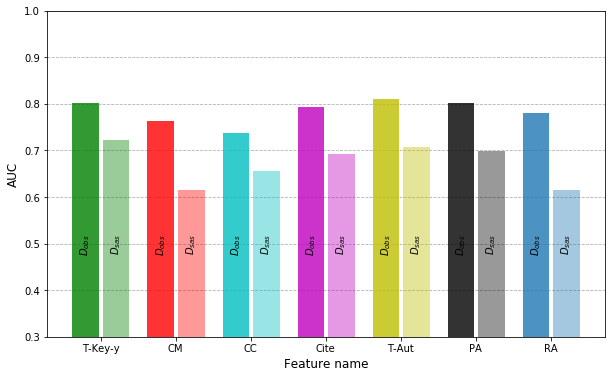

In [29]:
#######print and save auc figure
names = {'typeaut':'T-Aut','typeart':'T-Art','typenode':'T-Key','y_weight1':'T-Key-y',
         'res_aloc':'RA','cm':'CM','close':'CC','pref':'PA','citation':'Cite'}
colors = ['g','r','c','m','y','k','C0','C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
xtick=[]
fig, ax = plt.subplots(figsize=(10,6)) 
#fig = plt.figure(figsize=(10,6))
ax.set_axisbelow(True)
ax.grid(axis='y', linestyle='--')
plt.ylim(.3, 1)
bar_width = 0.35
result_lat = {'apnea':{},'obesity':{}}
for i in range(len(results_apnea)):
    name = results_apnea[i]['model name'].split('-')[3]
    result_lat['apnea'][names[name]]=results_apnea[i]['auc']
    result_lat['obesity'][names[name]]=results_obesity[i]['auc']
    ax.bar(i,results_obesity[i]['auc'] ,bar_width,align='center',alpha=0.8,color = colors[i])
    ax.text(i, .5,r'$D_{obs}$', color='k',horizontalalignment='center',rotation=90)
    ax.bar(i+bar_width+.06,results_apnea[i]['auc'] ,bar_width,align='center', alpha=0.4,color = colors[i])
    ax.text(i+bar_width+.06, .5, r'$D_{sas}$', color='k',horizontalalignment='center',rotation=90)
    xtick.append(names[name])
x_pos = np.arange(len(xtick))

plt.xticks(x_pos+.2, xtick, rotation=0)
plt.xlabel('Feature name', fontsize=12)
plt.ylabel('AUC', fontsize=12)
###show
plt.show()

#### Generate and save *PR* & *ROC* curves for both datasets and all features

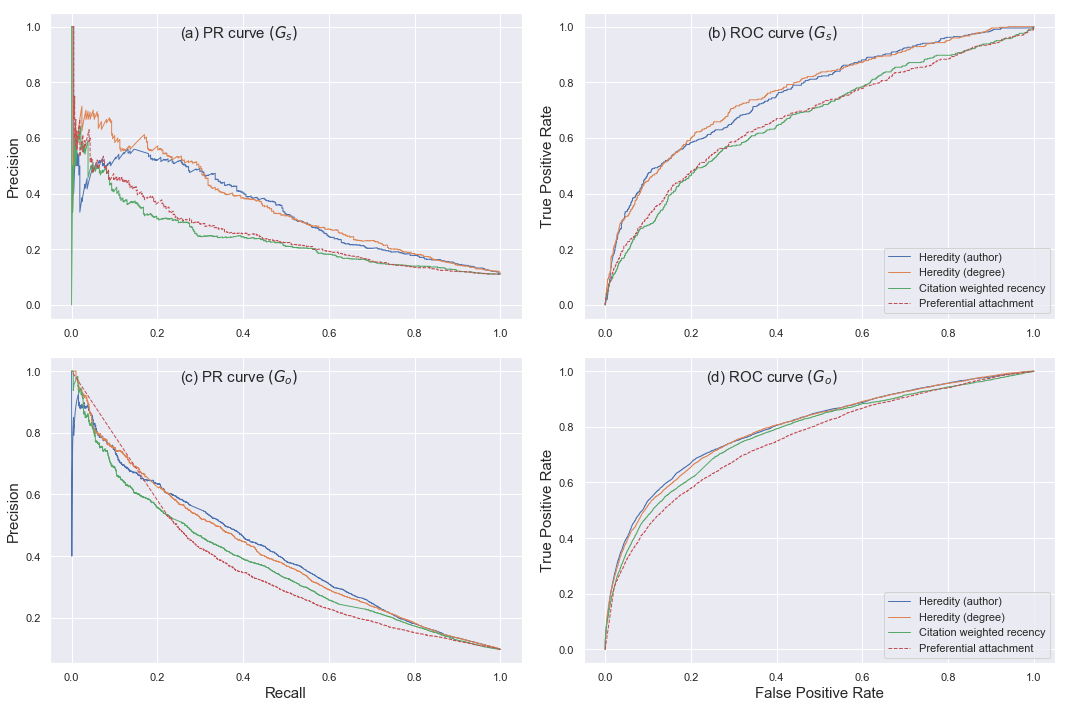

In [77]:
import seaborn as sns; sns.set(color_codes=True)
names = {'author':'Heredity (author)','article':'Heredity (article)','degree':'Heredity (degree)','y_weight1':'T-Key-y',
         'res_aloc':'RA','cm':'Common neighbour','close':'CC','pref':'Preferential attachment',
         'citation':'Citation weighted recency'}
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
for i,row in enumerate(results_apnea):
#     if i==1 or i==2 or i==5 or i==7:
    name = row['model name']
    if i==4:
        plt.plot(row['recall'],row['precision'],'--', linewidth=1,label = names[name])
    elif i==3 or i==0 or i==2:
        plt.plot(row['recall'],row['precision'],'-', linewidth=1,label = names[name])
# plt.legend(loc='best',fancybox=True)
plt.title("(a) PR curve $(G_{s})$", position=(0.4, 0.9),fontsize=15)
# plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=15)
plt.tight_layout()
plt.subplot(2,2,2)
for i,row in enumerate(results_apnea):
#     if i==1 or i==2 or i==5 or i==7:
    name = row['model name']
    if i==4:
        plt.plot(row['false positive'],row['true positive'],'--',linewidth=1,label = names[name])
    elif i==0 or i==3 or i==2:
        plt.plot(row['false positive'],row['true positive'],'-',linewidth=1,label = names[name])
plt.legend(loc='lower right')
plt.title("(b) ROC curve $(G_{s})$", position=(0.4, 0.9),fontsize=15)
# plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=15)
plt.tight_layout()

plt.subplot(2,2,3)
for i,row in enumerate(results_obesity):
#     if i==1 or i==2 or i==5 or i==7:
    name = row['model name']
    if i==4:
        plt.plot(row['recall'],row['precision'],'--',linewidth=1,label = names[name])
    elif i==3 or i==0 or i==2:
        plt.plot(row['recall'],row['precision'],'-',linewidth=1,label = names[name])
# plt.legend(loc='best')
plt.title("(c) PR curve $(G_{o})$", position=(0.4, 0.9),fontsize=15)
plt.xlabel('Recall', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.tight_layout()
plt.subplot(2,2,4)
for i,row in enumerate(results_obesity):
#     if i==1 or i==2 or i==5 or i==7:
    name = row['model name']
    if i==4:
        plt.plot(row['false positive'],row['true positive'],'--',linewidth=1,label = names[name])
    elif i==3 or i==0 or i==2:
        plt.plot(row['false positive'],row['true positive'],'-',linewidth=1,label = names[name])
plt.legend(loc='lower right')
plt.title("(d) ROC curve $(G_{o})$", position=(0.4, 0.9),fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.tight_layout()
###save
figpath=root+'dataframes/'
fig_file_name = os.path.join(figpath,'pr-roc-100'+ ".pdf")
plt.savefig(fig_file_name)
#show
plt.show()

#### Generate *LATEX* table containing *AUC* values for both dataset-features

In [35]:
result_lat
result_df = pd.DataFrame(result_lat)
#####generate latex table of auc values
print(result_df.to_latex(float_format=lambda x: '%.2f' % x))

\begin{tabular}{lrr}
\toprule
{} &  apnea &  obesity \\
\midrule
CC      &   0.65 &     0.74 \\
CM      &   0.61 &     0.76 \\
Cite    &   0.69 &     0.79 \\
PA      &   0.70 &     0.80 \\
RA      &   0.62 &     0.78 \\
T-Aut   &   0.71 &     0.81 \\
T-Key-y &   0.72 &     0.80 \\
\bottomrule
\end{tabular}



#### Gephi graph formated (gexf) graph generate and save

In [23]:
ts = time[1]
te = time[2]
label = dict(zip(key_list['id'], key_list['keyword']))
for t in range(ts,te):
    gephy_g = nx.Graph()
    nodes = list(g_train[t].nodes())
    edges = list(g_train[t].edges())
    gephy_g.add_nodes_from(nodes,year=t)
    gephy_g.add_edges_from(edges,year=t)
    aut = dict(zip(node_feature[t]['node_index'], node_feature[t]['term_aut']))
    aut_types = dict(zip(node_feature[t]['node_index'], node_feature[t]['node_type_aut']))
    art = dict(zip(node_feature[t]['node_index'], node_feature[t]['term_art']))
    art_types = dict(zip(node_feature[t]['node_index'], node_feature[t]['node_type_art']))
    deg = dict(zip(node_feature[t]['node_index'], node_feature[t]['degree']))
    deg_types = dict(zip(node_feature[t]['node_index'], node_feature[t]['node_type_deg']))
    nx.set_node_attributes(gephy_g, aut, 'aut')
    nx.set_node_attributes(gephy_g, art, 'art')
    nx.set_node_attributes(gephy_g, deg, 'deg')
    nx.set_node_attributes(gephy_g, label, 'label')
    nx.set_node_attributes(gephy_g, aut_types, 'aut_types')
    nx.set_node_attributes(gephy_g, art_types, 'art_types')
    nx.set_node_attributes(gephy_g, deg_types, 'deg_types')
    file = "gephy\g-apnea-"+str(t)+".gexf"
    nx.write_gexf(gephy_g, file)

In [17]:
node_feature[t].head()

,node_index,y_weight,term_art,term_aut,term_af1,term_af2,term_coun,closeness,degree,citation,degrees,node_type_aut,node_type_art,node_type_deg
0,7307,1,0.678311,0.547600,0.466307,0.499934,-0.088578,0.408548,18,35,0.009688,5,5,5
1,9428,1,0.681091,0.733622,0.673272,0.609504,0.530057,0.408381,18,36,0.009688,5,5,5
2,1456,1,2.515043,2.452285,2.341771,2.099439,1.728880,0.418465,58,317,0.031216,5,5,5
3,6394,1,2.721442,2.556688,2.698300,2.340104,2.334294,0.423817,60,219,0.032293,5,5,5
4,305,1,-0.004512,0.310886,0.036645,0.101198,0.004869,0.308929,8,25,0.004306,5,5,5


In [24]:
p1 = set(train_data[2008]['row_name'][(train_data[2008]['label']==1)])

In [111]:
p={}
n={}
nods={}
edgs={}
for t in range(2008,2015,1):
#     p[t]=set(train_data[t]['row_name'][(train_data[t]['label']==0)])
#     n[t]=set(train_data[t]['row_name'][(train_data[t]['label']==0)])
#    p[t]=set(g_train[t].nodes())
#     p[t]=set(g_train[t].edges())
     p[t]=set(nx.non_edges(g_train[t]))

In [112]:
ll=[]
ll.append(len(p[2008]))
ll.append(len(p[2009].difference(p[2008])))
ll.append(len(p[2010].difference(p[2008],p[2009])))
ll.append(len(p[2011].difference(p[2008],p[2009],p[2010])))
ll.append(len(p[2012].difference(p[2008],p[2009],p[2010],p[2011])))
ll.append(len(p[2013].difference(p[2008],p[2009],p[2010],p[2011],p[2012])))
ll.append(len(p[2014].difference(p[2008],p[2009],p[2010],p[2011],p[2012],p[2013])))

In [74]:
for mod in results_apnea:
    print(mod['model name'],mod['auc'],mod['test accuracy'])

apnea-2008-2015-typenode 0.6991790370672357 0.90135963749358
apnea-2008-2015-cm 0.6117696667386108 0.90135963749358
apnea-2008-2015-typeart 0.6991646482329712 0.90135963749358
apnea-2008-2015-typeaut 0.6996354828652965 0.90135963749358
apnea-2008-2015-pref 0.6727427516247392 0.90135963749358
apnea-2008-2015-citation1 0.7021779099418851 0.90135963749358


In [69]:
for mod in results_obesity:
    print(mod['model name'],mod['auc'],mod['test accuracy'])

obesity-2008-2015-typenode 0.7979005265646204 0.9069357123080123
obesity-2008-2015-cm 0.763067103304695 0.9064387067664005
obesity-2008-2015-typeart 0.8000309948891937 0.9066623592601257
obesity-2008-2015-typeaut 0.7980460909117967 0.9067369100913676
obesity-2008-2015-pref 0.8018239971521064 0.9068920052781688
obesity-2008-2015-citation1 0.8102702909035886 0.9069108620309316
